<a href="https://colab.research.google.com/github/rizqynur/IBMGranite-ABSA-Cyberbullying/blob/main/IBM_Project_ABSA_Bullying_IBM_Granite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain_community
!pip install replicate
!pip install pandas
!pip install openpyxl  # Untuk membaca file Excel
!pip install scikit-learn  # Untuk confusion matrix dan metrics
!pip install nltk  # Untuk preprocessing jika diperlukan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.74
    Uninstalling langchain-core-0.3.74:
      Successfully uninstalled langchain-core-0.3.74
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 1.9 MB

In [ ]:
import pandas as pd
import os
from langchain_community.llms import Replicate
from google.colab import userdata
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Set the API token
api_token = userdata.get('REPLICATE_API_TOKEN')
os.environ["REPLICATE_API_TOKEN"] = api_token

# Model setup
model = "ibm-granite/granite-3.1-8b-instruct"
llm = Replicate(
    model=model,
    replicate_api_token=api_token,
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Load dataset utama
df = pd.read_excel('DATASET CYBERBULLYING INSTAGRAM - FINAL.xlsx', sheet_name='Sheet1')

# Load kamus singkatan
kamus_singkatan = pd.read_csv('kamus_singkatan.csv', header=None, names=['singkatan', 'asli'])

# Load stopwords
stopwords_df = pd.read_csv('stopwordsID.csv', header=None, names=['stopword'])
stop_words = set(stopwords_df['stopword'].tolist())

# Tampilkan sampel data
print(df.head())

   No.  Nama Instagram                                           Komentar  \
0    1    @delliananda        "Kaka tidur yaa, udah pagi, gaboleh capek2"   
1    2       @fenninbl            "makan nasi padang aja begini badannya"   
2    3  @abdurahmanshq  "yang aku suka dari dia adalah selalu cukur je...   
3    4      @najla.yoo  "Hai kak Isyana aku ngefans banget sama kak Is...   
4    5   @dessy_______  "Manusia apa bidadari sih herann deh cantik te...   

       Kategori  Tanggal Posting Nama Akun IG  Artis/Selebgram  Unnamed: 6  \
0  Non-bullying  14 Oktober 2019              @isyanasarasvati         NaN   
1  Non-bullying  14 Oktober 2019              @isyanasarasvati         NaN   
2      Bullying  14 Oktober 2019              @isyanasarasvati         NaN   
3  Non-bullying  14 Oktober 2019              @isyanasarasvati         NaN   
4  Non-bullying  14 Oktober 2019              @isyanasarasvati         NaN   

   Unnamed: 7  
0         NaN  
1         NaN  
2         NaN  
3   

In [ ]:
# Preprocessing Function
def preprocess_text(text, kamus_singkatan, stop_words):
    # Lowercase
    text = text.lower()

    # Ganti singkatan menggunakan kamus
    singkatan_dict = dict(zip(kamus_singkatan['singkatan'], kamus_singkatan['asli']))
    for singkatan, asli in singkatan_dict.items():
        text = re.sub(r'\b' + singkatan + r'\b', asli, text)

    # Remove special characters, numbers, punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]

    # Join back to string
    text = ' '.join(tokens)

    return text

# Apply preprocessing to 'Komentar' column
df['Komentar_Clean'] = df['Komentar'].apply(lambda x: preprocess_text(x, kamus_singkatan, stop_words))

# Map labels: Bullying -> Negatif (0), Non-bullying -> Positif (1)
df['Label'] = df['Kategori'].map({'Bullying': 0, 'Non-bullying': 1})

# Tampilkan sampel setelah preprocessing
print(df[['Komentar', 'Komentar_Clean', 'Kategori', 'Label']].head())

                                            Komentar  \
0        "Kaka tidur yaa, udah pagi, gaboleh capek2"   
1            "makan nasi padang aja begini badannya"   
2  "yang aku suka dari dia adalah selalu cukur je...   
3  "Hai kak Isyana aku ngefans banget sama kak Is...   
4  "Manusia apa bidadari sih herann deh cantik te...   

                                      Komentar_Clean      Kategori  Label  
0                          kaka tidur yaa pagi capek  Non-bullying      1  
1                         makan nasi padang badannya  Non-bullying      1  
2                         suka cukur jembut manggung      Bullying      0  
3  hai kak isyana ngefans kak isyanasaya suka lag...  Non-bullying      1  
4             manusia bidadari sih herann deh cantik  Non-bullying      1  


In [ ]:
# Split Data into Train and Test (70% Train, 30% Test)
# Dataset train untuk contoh few-shot prompting, test untuk evaluasi
X = df['Komentar_Clean']
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Buat DataFrame untuk train dan test
train_df = pd.DataFrame({'Komentar_Clean': X_train, 'Label': y_train})
test_df = pd.DataFrame({'Komentar_Clean': X_test, 'Label': y_test})

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

Train size: 455, Test size: 195


In [ ]:
# Define Few-Shot Examples from Train Data
# Ambil beberapa contoh dari train untuk few-shot prompting

few_shot_examples = []

# Contoh negatif (Bullying)
neg_examples = train_df[train_df['Label'] == 0].sample(5)
for _, row in neg_examples.iterrows():
    few_shot_examples.append(f"Komentar: {row['Komentar_Clean']}\nSentimen: Negatif\nAspek: [ekstrak aspek, misal: muka, badan, perilaku]")

# Contoh positif (Non-bullying)
pos_examples = train_df[train_df['Label'] == 1].sample(5)
for _, row in pos_examples.iterrows():
    few_shot_examples.append(f"Komentar: {row['Komentar_Clean']}\nSentimen: Positif\nAspek: [ekstrak aspek, misal: penampilan, kepribadian]")

few_shot_prompt = "\n\n".join(few_shot_examples)

In [ ]:
# Define Prompt Template for ABSA
# Prompt untuk IBM Granite: Analisis sentimen dan ekstrak aspek
prompt_template = """
Anda adalah ahli dalam Aspect Based Sentiment Analysis (ABSA). Analisis komentar Instagram berikut terkait isu bullying.

Contoh-contoh:
{few_shot_examples}

Sekarang, analisis komentar ini:
Komentar: {komentar}

Output dalam format berikut:
Sentimen: [Positif/Negatif]
Aspek: [daftar aspek yang dipuji/dibully, dipisah koma, misal: muka, badan, perilaku]
Penjelasan: [penjelasan singkat]
"""

In [ ]:
# Function to Run Inference with Granite
def analyze_comment(komentar, parameters):
    full_prompt = prompt_template.format(few_shot_examples=few_shot_prompt, komentar=komentar)
    response = llm.invoke(full_prompt, parameters=parameters)
    return response

# Set default parameters (sama seperti contoh sebelumnya, adjust jika perlu)
parameters = {
    "top_k": 0,
    "top_p": 1.0,
    "max_tokens": 256,
    "min_tokens": 0,
    "random_seed": None,
    "repetition_penalty": 1.0,
    "stopping_criteria": "length (256 tokens)",
    "stopping_sequence": None
}

In [ ]:
# Run Inference on Test Set
# Prediksi untuk setiap test sample
predictions = []
aspects_list = []  # Simpan aspek untuk analisis tambahan jika perlu

for komentar in X_test:
    response = analyze_comment(komentar, parameters)

    # Parse response (asumsikan format konsisten, adjust parsing jika perlu)
    sentimen = "Positif" if "Positif" in response else "Negatif"
    aspek_start = response.find("Aspek:") + len("Aspek:")
    aspek_end = response.find("Penjelasan:")
    aspek = response[aspek_start:aspek_end].strip() if aspek_start > -1 and aspek_end > -1 else "Tidak ada"

    predictions.append(1 if sentimen == "Positif" else 0)  # 1: Positif, 0: Negatif
    aspects_list.append(aspek)

    print(f"Komentar: {komentar}\nPrediksi: {sentimen}\nAspek: {aspek}\n")

# Tambahkan prediksi ke test_df
test_df['Prediksi'] = predictions
test_df['Aspek'] = aspects_list

Komentar: aduuh halu hhahaha lebay editan nyaa lemak lemak hahhaaa mimpi ketinggian
Prediksi: Negatif
Aspek: editan, lemak

Komentar: jujur suka meldi suka ngehujat orang
Prediksi: Negatif
Aspek: perilaku

Komentar: cantikcantik hahaha
Prediksi: Positif
Aspek: muka

Komentar: mengharap ikutan kontes miss earth les inggris biar lidahnya keseleo
Prediksi: Negatif
Aspek: muka

Komentar: melet setan kaya ular
Prediksi: Negatif
Aspek: muka

Komentar: meldi kontrak endorse skincare mukanya jelek si
Prediksi: Negatif
Aspek: muka

Komentar: sumpah bagus serasa liat cerita disney
Prediksi: Positif
Aspek: cerita

Komentar: selamat ulang umur ketemu dajjal
Prediksi: Negatif
Aspek: [ulang tahun, dajjal]

Komentar: ranggakanahaya truck sampah kek mukanya sampah
Prediksi: Negatif
Aspek: muka

Komentar: cakap kaga jelek iya hahah
Prediksi: Negatif
Aspek: muka

Komentar: sebelah kanan batik orang warna kek taek babi si
Prediksi: Negatif
Aspek: muka, warna

Komentar: jelek selingkuhan jelek keren yaa i

In [ ]:
# Evaluate Model - Confusion Matrix and Metrics
# True labels: y_test (0: Negatif, 1: Positif)

cm = confusion_matrix(y_test, predictions)
acc = accuracy_score(y_test, predictions)
prec = precision_score(y_test, predictions, average='weighted')
rec = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

print("Confusion Matrix:\n", cm)
print(f"Accuracy: {acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1-Score: {f1}")

# Optional: Tampilkan test_df dengan prediksi dan aspek
print(test_df[['Komentar_Clean', 'Label', 'Prediksi', 'Aspek']])

Confusion Matrix:
 [[86 12]
 [40 57]]
Accuracy: 0.7333333333333333
Precision: 0.7539452495974236
Recall: 0.7333333333333333
F1-Score: 0.7275100401606426
                                        Komentar_Clean  Label  Prediksi  \
107  aduuh halu hhahaha lebay editan nyaa lemak lem...      0         0   
115               jujur suka meldi suka ngehujat orang      1         0   
79                                 cantikcantik hahaha      0         1   
141  mengharap ikutan kontes miss earth les inggris...      0         0   
350                              melet setan kaya ular      0         0   
..                                                 ...    ...       ...   
499  bodoh alam semesta seisinya serentak murka men...      0         0   
396                      meninggalkan berlian tai sapi      0         0   
19   anaknya pintar maknya kelempengan berasa baby ...      0         0   
80   kasihan editornya sih nanggung dosa kayaknya n...      0         0   
391  biarin xrickolim 

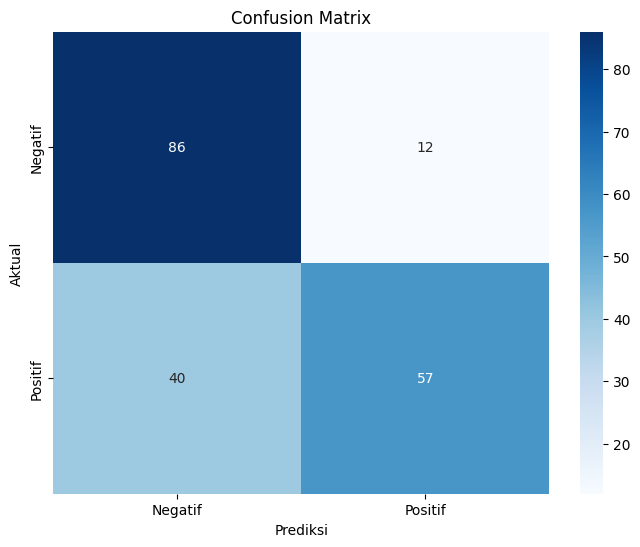

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Define Function to Run Experiment with Parameters

def run_experiment(parameters, X_test, y_test):
    predictions = []
    aspects_list = []

    for komentar in X_test:
        response = analyze_comment(komentar, parameters)

        # Parse response
        sentimen = "Positif" if "Positif" in response else "Negatif"
        aspek_start = response.find("Aspek:") + len("Aspek:")
        aspek_end = response.find("Penjelasan:")
        aspek = response[aspek_start:aspek_end].strip() if aspek_start > -1 and aspek_end > -1 else "Tidak ada"

        predictions.append(1 if sentimen == "Positif" else 0)
        aspects_list.append(aspek)

    # Evaluasi
    cm = confusion_matrix(y_test, predictions)
    acc = accuracy_score(y_test, predictions)
    prec = precision_score(y_test, predictions, average='weighted')
    rec = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    print(f"Parameters: {parameters}")
    print("Confusion Matrix:\n", cm)
    print(f"Accuracy: {acc}")
    print(f"Precision: {prec}")
    print(f"Recall: {rec}")
    print(f"F1-Score: {f1}\n")

    return predictions, aspects_list, acc, prec, rec, f1

In [ ]:
# Variasi 1 - Default Parameters
parameters_1 = {
    "top_k": 0,
    "top_p": 1.0,
    "max_tokens": 256,
    "min_tokens": 0,
    "random_seed": None,
    "repetition_penalty": 1.0,
    "stopping_criteria": "length (256 tokens)",
    "stopping_sequence": None
}

predictions_1, aspects_1, acc_1, prec_1, rec_1, f1_1 = run_experiment(parameters_1, X_test, y_test)

Parameters: {'top_k': 0, 'top_p': 1.0, 'max_tokens': 256, 'min_tokens': 0, 'random_seed': None, 'repetition_penalty': 1.0, 'stopping_criteria': 'length (256 tokens)', 'stopping_sequence': None}
Confusion Matrix:
 [[87 11]
 [42 55]]
Accuracy: 0.7282051282051282
Precision: 0.7534684953289605
Recall: 0.7282051282051282
F1-Score: 0.7209182842598155



In [ ]:
# Variasi 2 - top_k=5, top_p=1.0, max_tokens=256, min_tokens=0
parameters_2 = {
    "top_k": 5,
    "top_p": 1.0,
    "max_tokens": 256,
    "min_tokens": 0,
    "random_seed": None,
    "repetition_penalty": 1.0,
    "stopping_criteria": "length (256 tokens)",
    "stopping_sequence": None
}

predictions_2, aspects_2, acc_2, prec_2, rec_2, f1_2 = run_experiment(parameters_2, X_test, y_test)

Parameters: {'top_k': 5, 'top_p': 1.0, 'max_tokens': 256, 'min_tokens': 0, 'random_seed': None, 'repetition_penalty': 1.0, 'stopping_criteria': 'length (256 tokens)', 'stopping_sequence': None}
Confusion Matrix:
 [[87 11]
 [40 57]]
Accuracy: 0.7384615384615385
Precision: 0.7612445220365553
Recall: 0.7384615384615385
F1-Score: 0.7323325563325563



In [ ]:
# Variasi 3 - top_k=1, top_p=0.5, max_tokens=100, min_tokens=10
parameters_3 = {
    "top_k": 1,
    "top_p": 0.5,
    "max_tokens": 100,
    "min_tokens": 10,
    "random_seed": None,
    "repetition_penalty": 1.5,
    "stopping_criteria": "length",
    "stopping_sequence": None
}

predictions_3, aspects_3, acc_3, prec_3, rec_3, f1_3 = run_experiment(parameters_3, X_test, y_test)

Parameters: {'top_k': 1, 'top_p': 0.5, 'max_tokens': 100, 'min_tokens': 10, 'random_seed': None, 'repetition_penalty': 1.5, 'stopping_criteria': 'length', 'stopping_sequence': None}
Confusion Matrix:
 [[85 13]
 [43 54]]
Accuracy: 0.7128205128205128
Precision: 0.7346524588595483
Recall: 0.7128205128205128
F1-Score: 0.7056146817424607



In [ ]:
# Variasi 4 - top_k=10, top_p=0.9, max_tokens=50, min_tokens=5
parameters_4 = {
    "top_k": 10,
    "top_p": 0.9,
    "max_tokens": 50,
    "min_tokens": 5,
    "random_seed": None,
    "repetition_penalty": 1.5,
    "stopping_criteria": "length (256 tokens)",
    "stopping_sequence": " "
}

predictions_4, aspects_4, acc_4, prec_4, rec_4, f1_4 = run_experiment(parameters_4, X_test, y_test)

Parameters: {'top_k': 10, 'top_p': 0.9, 'max_tokens': 50, 'min_tokens': 5, 'random_seed': None, 'repetition_penalty': 1.5, 'stopping_criteria': 'length (256 tokens)', 'stopping_sequence': ' '}
Confusion Matrix:
 [[83 15]
 [40 57]]
Accuracy: 0.717948717948718
Precision: 0.7329320408588701
Recall: 0.717948717948718
F1-Score: 0.7130400635447623



In [ ]:
# Variasi 5 - top_k=0, top_p=0.7, max_tokens=200, min_tokens=0
parameters_5 = {
    "top_k": 0,
    "top_p": 0.7,
    "max_tokens": 200,
    "min_tokens": 0,
    "random_seed": None,
    "repetition_penalty": 1.0,
    "stopping_criteria": "length (256 tokens)",
    "stopping_sequence": None
}

predictions_5, aspects_5, acc_5, prec_5, rec_5, f1_5 = run_experiment(parameters_5, X_test, y_test)

Parameters: {'top_k': 0, 'top_p': 0.7, 'max_tokens': 200, 'min_tokens': 0, 'random_seed': None, 'repetition_penalty': 1.0, 'stopping_criteria': 'length (256 tokens)', 'stopping_sequence': None}
Confusion Matrix:
 [[87 11]
 [39 58]]
Accuracy: 0.7435897435897436
Precision: 0.7651430694908955
Recall: 0.7435897435897436
F1-Score: 0.7379904232313872



In [ ]:
parameters_6 = {
    "top_k": 0,
    "top_p": 0.9,
    "max_tokens": 300,
    "min_tokens": 0,
    "temperature": 0.7,
    "repetition_penalty": 1.0,
    "stopping_criteria": "length",
    "stopping_sequence": None
}

predictions_6, aspects_6, acc_6, prec_6, rec_6, f1_6 = run_experiment(parameters_6, X_test, y_test)

Parameters: {'top_k': 0, 'top_p': 0.9, 'max_tokens': 300, 'min_tokens': 0, 'temperature': 0.7, 'repetition_penalty': 1.0, 'stopping_criteria': 'length', 'stopping_sequence': None}
Confusion Matrix:
 [[86 12]
 [39 58]]
Accuracy: 0.7384615384615385
Precision: 0.7579252747252747
Recall: 0.7384615384615385
F1-Score: 0.7331522536162585



In [ ]:
# Summary of All Variations
print("Summary of Experiments:")
print("Variasi 1 - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(acc_1, prec_1, rec_1, f1_1))
print("Variasi 2 - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(acc_2, prec_2, rec_2, f1_2))
print("Variasi 3 - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(acc_3, prec_3, rec_3, f1_3))
print("Variasi 4 - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(acc_4, prec_4, rec_4, f1_4))
print("Variasi 5 - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(acc_5, prec_5, rec_5, f1_5))

Summary of Experiments:
Variasi 1 - Accuracy: 0.7282, Precision: 0.7535, Recall: 0.7282, F1: 0.7209
Variasi 2 - Accuracy: 0.7385, Precision: 0.7612, Recall: 0.7385, F1: 0.7323
Variasi 3 - Accuracy: 0.7128, Precision: 0.7347, Recall: 0.7128, F1: 0.7056
Variasi 4 - Accuracy: 0.7179, Precision: 0.7329, Recall: 0.7179, F1: 0.7130
Variasi 5 - Accuracy: 0.7436, Precision: 0.7651, Recall: 0.7436, F1: 0.7380


Visualisasi

In [ ]:
!pip install wordcloud
!pip install matplotlib
!pip install seaborn

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

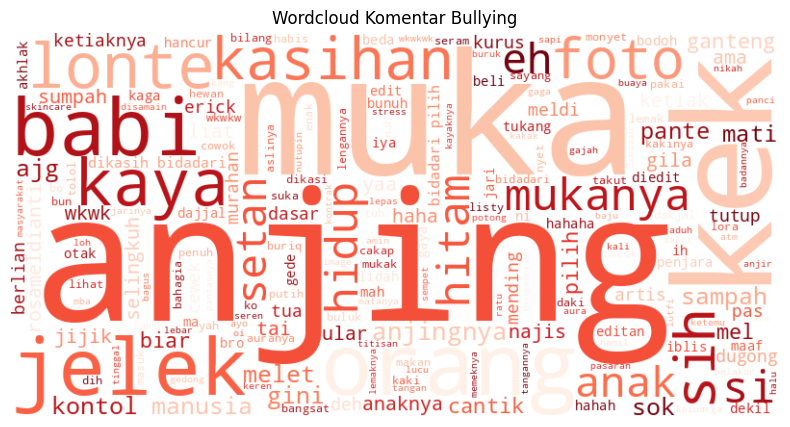

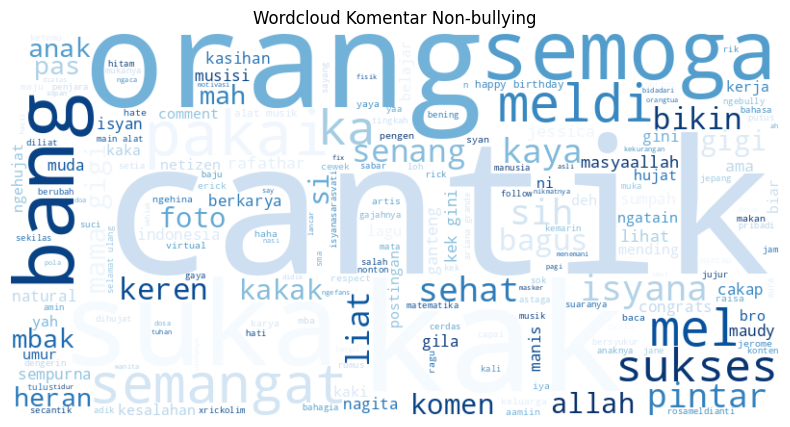

In [ ]:
# Wordcloud untuk Komentar Bullying dan Non-bullying

bullying_text = ' '.join(df[df['Kategori'] == 'Bullying']['Komentar_Clean'])
non_bullying_text = ' '.join(df[df['Kategori'] == 'Non-bullying']['Komentar_Clean'])

# Wordcloud untuk Bullying
wordcloud_bullying = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(bullying_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_bullying, interpolation='bilinear')
plt.title('Wordcloud Komentar Bullying')
plt.axis('off')
plt.show()

# Wordcloud untuk Non-bullying
wordcloud_non_bullying = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(non_bullying_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non_bullying, interpolation='bilinear')
plt.title('Wordcloud Komentar Non-bullying')
plt.axis('off')
plt.show()

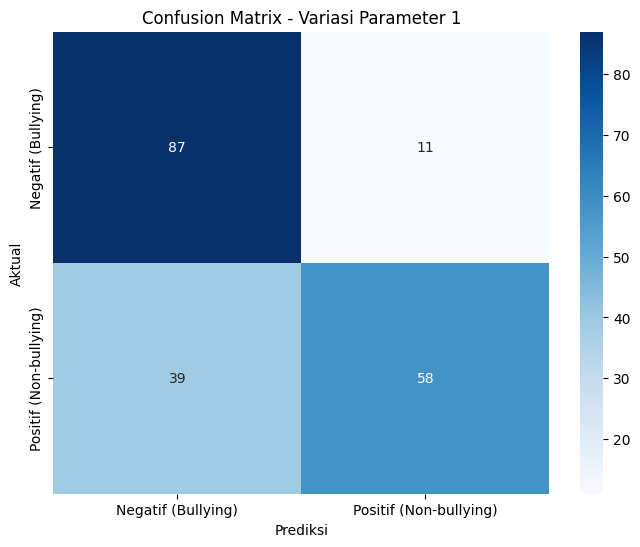

In [ ]:
# Cell 22: Visualisasi Confusion Matrix (Contoh dari Variasi 1)
# Asumsikan cm dari Variasi 1 (ganti dengan cm dari variasi lain jika perlu)
cm = confusion_matrix(y_test, predictions_5)  # Dari Cell 12

# Heatmap Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif (Bullying)', 'Positif (Non-bullying)'],
            yticklabels=['Negatif (Bullying)', 'Positif (Non-bullying)'])
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix - Variasi Parameter Optimal')
plt.show()

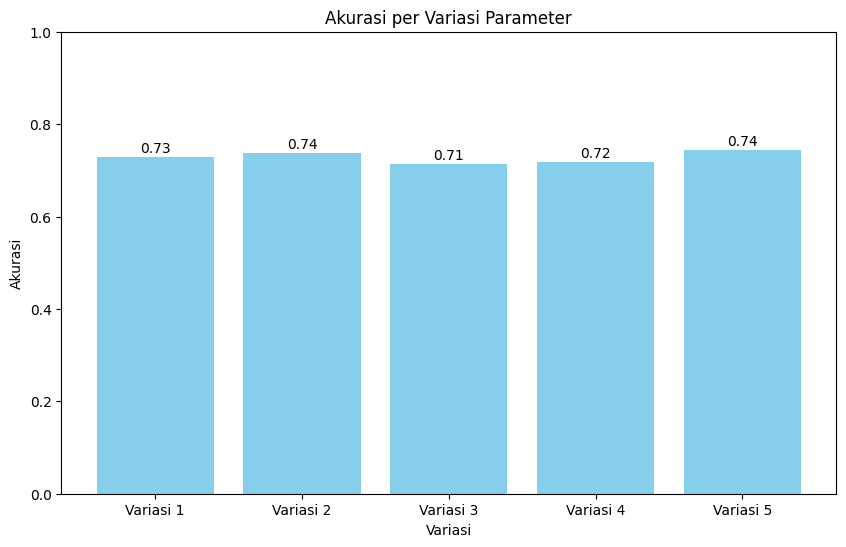

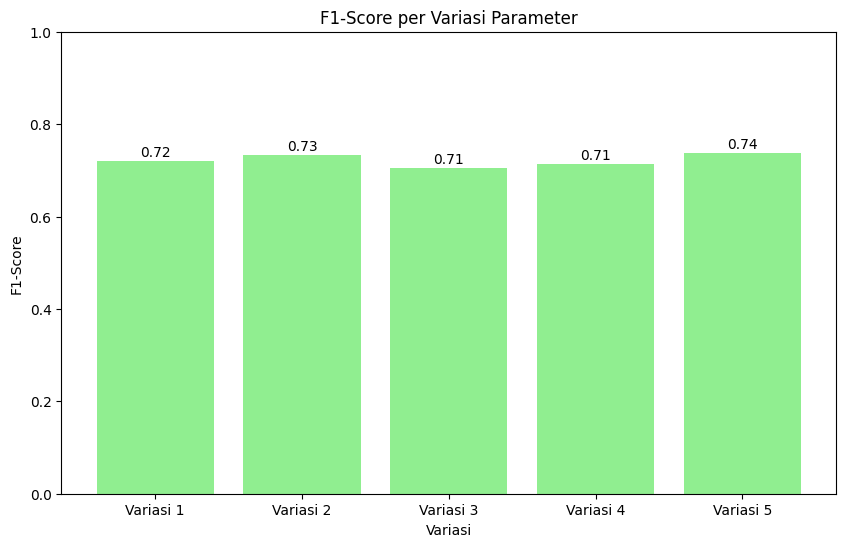

In [ ]:
# Visualisasi Metrics Per Variasi Parameter
# Kumpulkan metrics dari 5 variasi (dari Cell 17)
variations = ['Variasi 1', 'Variasi 2', 'Variasi 3', 'Variasi 4', 'Variasi 5']
accuracies = [acc_1, acc_2, acc_3, acc_4, acc_5]
precisions = [prec_1, prec_2, prec_3, prec_4, prec_5]
recalls = [rec_1, rec_2, rec_3, rec_4, rec_5]
f1_scores = [f1_1, f1_2, f1_3, f1_4, f1_5]

# Bar chart untuk Accuracy
plt.figure(figsize=(10, 6))
plt.bar(variations, accuracies, color='skyblue')
plt.title('Akurasi per Variasi Parameter')
plt.xlabel('Variasi')
plt.ylabel('Akurasi')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
plt.show()

# Bar chart untuk F1-Score (contoh, bisa duplikat untuk precision/recall)
plt.figure(figsize=(10, 6))
plt.bar(variations, f1_scores, color='lightgreen')
plt.title('F1-Score per Variasi Parameter')
plt.xlabel('Variasi')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
plt.show()

/tmp/ipython-input-3750488489.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(aspek_freq.keys()), y=list(aspek_freq.values()), palette='viridis')


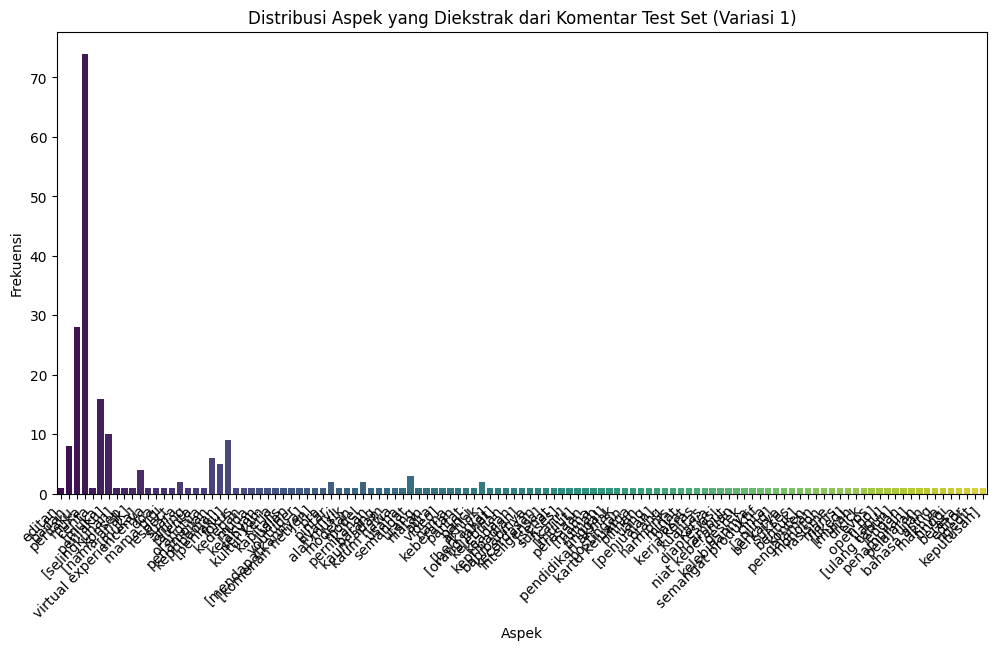

In [ ]:
# Visualisasi Distribusi Aspek yang Diekstrak (dari Test Set, Variasi 1)

all_aspects = []
for aspek in aspects_1:
    if aspek != "Tidak ada":
        all_aspects.extend([a.strip() for a in aspek.split(',')])

# Hitung frekuensi aspek
aspek_freq = Counter(all_aspects)

# Bar chart untuk frekuensi aspek
if aspek_freq:
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(aspek_freq.keys()), y=list(aspek_freq.values()), palette='viridis')
    plt.title('Distribusi Aspek yang Diekstrak dari Komentar Test Set (Variasi 1)')
    plt.xlabel('Aspek')
    plt.ylabel('Frekuensi')
    plt.xticks(rotation=45, ha='right')
    plt.show()
else:
    print("Tidak ada aspek yang diekstrak untuk visualisasi.")